In [301]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
import warnings; warnings.simplefilter('ignore')
import datetime

## Ingest

The following script is executed as a simple EMR step. It loads the previous day's data locally to the EMR master node, uploads that data to S3 and the removes the local EMR file.

```
#!/usr/bin/env bash
DATE=$(date +"%Y-%m-%dT00:00:00.000" -d "1 day ago")
wget https://data.cityofchicago.org/resource/ydr8-5enu.json?issue_date=$DATE -O ~/inbound_$DATE.json
aws s3 cp inbound_$DATE.json s3://mybucket/raw/inbound_$DATE.json
rm ~/inbound_$DATE.json```

## Extract

To do some high level exploratory analsis, we lazily read files from s3, letting spark
infer the schema. 'FAILFAST' ensures if we encounter inconsistent schemas, we fail the read job

In [235]:
%%spark -o df

#read in our raw dataset
df = spark\
    .read\
    .option("header", "false")\
    .option('mode', 'FAILFAST')\
    .json(
        "s3://prod-dez/raw/inbound.json",
        multiLine=True
    )\
    .withColumn('lattitude', col('location.coordinates')[0])\
    .withColumn('longitude', col('location.coordinates')[1])\
    .drop('location')

We can then extract the schema if we wish and use it to validate our metadata

In [240]:
df\
.printSchema()

root
 |-- application_start_date: string (nullable = true)
 |-- building_fee_paid: string (nullable = true)
 |-- building_fee_unpaid: string (nullable = true)
 |-- building_fee_waived: string (nullable = true)
 |-- contact_10_city: string (nullable = true)
 |-- contact_10_name: string (nullable = true)
 |-- contact_10_state: string (nullable = true)
 |-- contact_10_type: string (nullable = true)
 |-- contact_10_zipcode: string (nullable = true)
 |-- contact_1_city: string (nullable = true)
 |-- contact_1_name: string (nullable = true)
 |-- contact_1_state: string (nullable = true)
 |-- contact_1_type: string (nullable = true)
 |-- contact_1_zipcode: string (nullable = true)
 |-- contact_2_city: string (nullable = true)
 |-- contact_2_name: string (nullable = true)
 |-- contact_2_state: string (nullable = true)
 |-- contact_2_type: string (nullable = true)
 |-- contact_2_zipcode: string (nullable = true)
 |-- contact_3_city: string (nullable = true)
 |-- contact_3_name: string (nullable

## Profile

Using the local sparkmagics allows us to collect our datafram back to the master node to leverage
pandas for more fine-grained analysis

In [215]:
%%local
df\
.head(10)

Output()

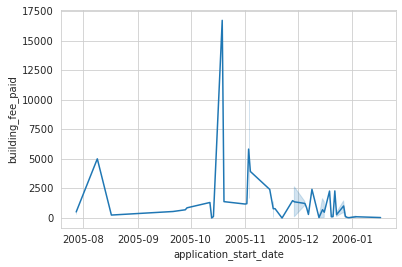

In [296]:
%matplotlib inline

##plotting reqs
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import datetime

sns.lineplot(
    data=df, 
    x="application_start_date", 
    y="building_fee_paid"
)

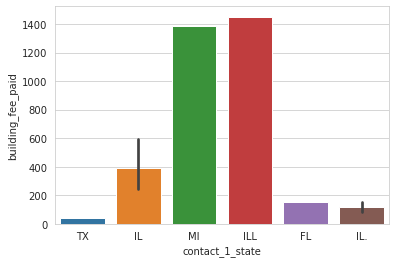

In [297]:
%matplotlib inline

sns.set_style("whitegrid")
sns.barplot(x=df.contact_1_state, y=df.building_fee_paid)

In [298]:
df\
.groupBy('contact_1_state')\
.agg(min('building_fee_paid'), max('building_fee_paid'))\
.show()

+---------------+----------------------+----------------------+
|contact_1_state|min(building_fee_paid)|max(building_fee_paid)|
+---------------+----------------------+----------------------+
|           null|                    85|                  87.5|
|             MI|                  1385|                  1385|
|            ILL|                  1450|                  1450|
|             IL|                     0|                  99.9|
|            IL.|                   155|                    85|
|             TX|                    40|                    40|
|             FL|                   150|                   150|
+---------------+----------------------+----------------------+

In [311]:
today = datetime.datetime.now()

df\
.write\
.save(
    "s3://dez-artifacts/prod-dez/demo_data_processed_{date}/".format(date=today.strftime('%Y-%m-%d')),
    'orc'
)